### Imports

In [5]:
import numpy as np 
from math import sqrt
import pandas as pd
import time
import os

from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split

import torchvision as tv

from torchvision.models.detection import ssd300_vgg16


import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data


### Setting

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

np.random.seed(21)
torch.manual_seed(21);

test = [0,2,14,17,28,29,30]

### Dataset

In [7]:
class BCCDDataset(torch.utils.data.Dataset):
    def __init__(self, root='/home/alex/projects/ml/ml_hw/hw_cv/bccd-dataset/', trans=None):
        super()
        self.root = root
        self.pds = pd.read_csv(os.path.join(root,"test.csv"))
        self.clases = ['Bachground'] + list(self.pds.cell_type.unique())
        self.clases_idx = {w: i for i, w in enumerate(self.clases)}
        self.transforms = tv.transforms.Compose([
               # tv.transforms.Resize([300, 300]),
                tv.transforms.ToTensor(),
                tv.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                ])
        self.imgs = self.pds.filename.unique()
        
    def get_image(self, idx):
        filename = self.imgs[idx]
        img = Image.open(os.path.join(self.root+'BCCD/JPEGImages',filename)).convert("RGB")
        return img
    
    def __getitem__(self, idx):
        filename = self.imgs[idx]
        img = Image.open(os.path.join(self.root+'BCCD/JPEGImages',filename)).convert("RGB")
        x = self.pds
        x = x[x.filename == filename]
        x = x[x.xmin < x.xmax]
        x = x[x.ymin < x.ymax]
        x = np.array(x)
        for i in range(len(x)):
            x[i,1]=self.clases_idx[x[i,1]]
        labels  = torch.as_tensor(x[:,1].astype(int), dtype=torch.int64).to(device)
        boxes = torch.as_tensor(x[:,[2,4,3,5]].astype(float), dtype=torch.float32).to(device)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((len(x),), dtype=torch.int64)


        img = self.transforms(img).to(device)

        return img, {'boxes':boxes, 'labels':labels}

    def __len__(self):
        return len(self.imgs)

### Model

In [8]:
model = ssd300_vgg16(weights='DEFAULT').to(device)
ds=BCCDDataset()


In [10]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%2dm %2ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

### Train

In [11]:
model.train()
trainer = torch.optim.Adam(model.parameters(), lr=1e-4)
start = time.time()
eps = 20
trn=list(set(range(len(ds)))-set(test))
for ep in range(eps):
    perm = np.random.permutation(trn)
    i = 0
    l0=0
    l1=0
    l2=0
    ln=0
    while True:
        pp=[]
        tt=[]
        trainer.zero_grad()
        for j in range(50):
            if i >= len(perm):
                break
            p,t = ds[perm[i]]
            pp.append(p)
            tt.append(t)
            i +=1
        pred = model(pp,tt)
        loss = pred['bbox_regression'] * pred['bbox_regression'] * 20 + pred['classification']
        loss.backward()
        trainer.step()  
        l1+=pred['bbox_regression'].item()
        l2+=pred['classification'].item()
        l0+=loss.item()
        ln+=1
        if i >= len(perm):
            break
    pc = (ep + 1) / eps 
    print('%s (%2d %3d%%) %8.4f %8.4f %8.4f' % 
          (timeSince(start, pc),ep,pc*100,l0/ln,l1/ln,l2/ln)) 

 0m 10s (-  3m 27s) ( 0   5%)  29.3197   1.0244   6.0278
 0m 20s (-  3m  5s) ( 1  10%)  10.4619   0.6286   2.5331
 0m 30s (-  2m 53s) ( 2  15%)   7.3797   0.5126   2.0707
 0m 40s (-  2m 42s) ( 3  20%)   6.3561   0.4706   1.9181
 0m 50s (-  2m 31s) ( 4  25%)   5.4221   0.4246   1.7974
 1m  0s (-  2m 21s) ( 5  30%)   4.7424   0.3882   1.7149
 1m 10s (-  2m 11s) ( 6  35%)   4.2173   0.3556   1.6639
 1m 20s (-  2m  1s) ( 7  40%)   3.9449   0.3409   1.6072
 1m 30s (-  1m 51s) ( 8  45%)   3.7381   0.3272   1.5866
 1m 41s (-  1m 41s) ( 9  50%)   3.3125   0.2964   1.5420
 1m 51s (-  1m 31s) (10  55%)   3.1795   0.2872   1.5223
 2m  1s (-  1m 20s) (11  60%)   2.9314   0.2691   1.4791
 2m 11s (-  1m 10s) (12  65%)   2.6908   0.2491   1.4470
 2m 21s (-  1m  0s) (13  70%)   2.5389   0.2363   1.4176
 2m 31s (-  0m 50s) (14  75%)   2.4056   0.2222   1.4173
 2m 41s (-  0m 40s) (15  80%)   2.2402   0.2089   1.3617
 2m 51s (-  0m 30s) (16  85%)   2.1351   0.1996   1.3367
 3m  1s (-  0m 20s) (17  90%)  

### eval

In [12]:
model = model.to('cpu')

In [13]:
device = 'cpu'

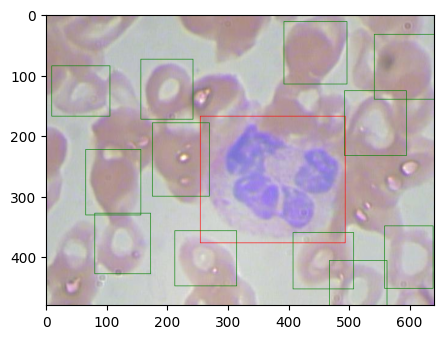

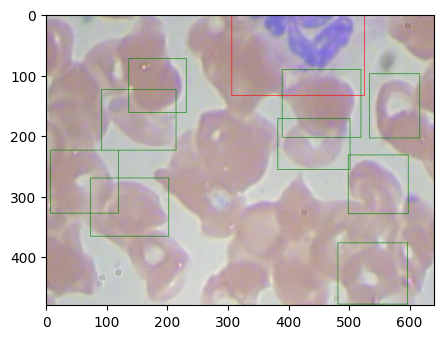

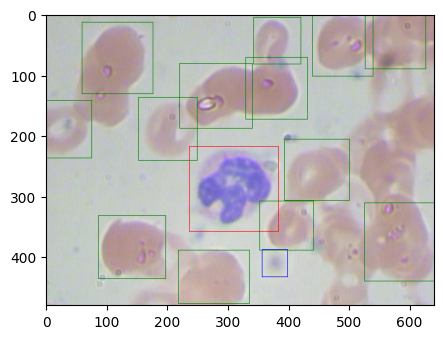

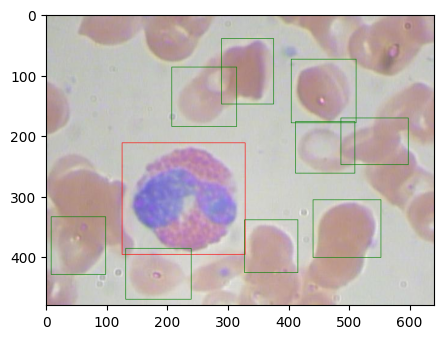

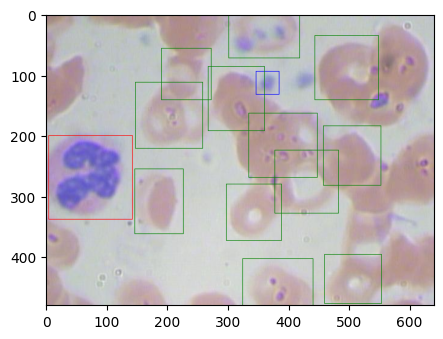

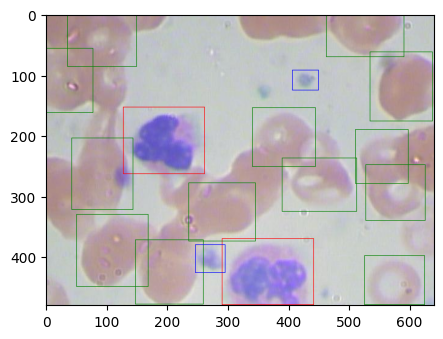

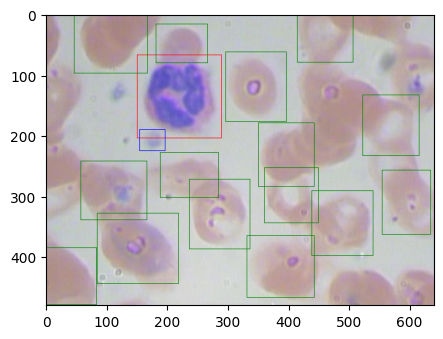

In [14]:
model.eval()
for i in test:
    p,t = ds[i]
    outputs = model([p])
    img = ds.get_image(i)
    draw = ImageDraw.Draw(img)
    classes = outputs[0]['labels'].cpu().numpy()
    scores = outputs[0]['scores'].detach().cpu().numpy()
    boxes = outputs[0]['boxes'].detach().cpu().numpy()

    for i,box in enumerate(boxes):
        if scores[i] > 0.5 :
            c = classes[i]
            c = c if c < 4 else 0
            cl = ['black','red','green','blue']
            draw.rectangle(xy=box.tolist(), outline=cl[c])
    plt.figure(figsize=(5, 5))
    plt.imshow(img)